# Regression with DNN

**Objectives :**

* Predicts housing prices from a set of house features.
* Understanding the principle and the architecture of a regression with a dense neural network with backup and restore of the trained model.

The [Boston Housing Prices Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) consists of price of houses in various places in Boston.
Alongside with price, the dataset also provide these information :

* CRIM: This is the per capita crime rate by town
* ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft
* INDUS: This is the proportion of non-retail business acres per town
* CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
* NOX: This is the nitric oxides concentration (parts per 10 million)
* RM: This is the average number of rooms per dwelling
* AGE: This is the proportion of owner-occupied units built prior to 1940
* DIS: This is the weighted distances to five Boston employment centers
* RAD: This is the index of accessibility to radial highways
* TAX: This is the full-value property-tax rate per 10,000 dollars
* PTRATIO: This is the pupil-teacher ratio by town
* B: This is calculated as 1000(Bk — 0.63)^2, where Bk is the proportion of people of African American descent by town
* LSTAT: This is the percentage lower status of the population
* MEDV: This is the median value of owner-occupied homes in 1000 dollars

**What we're going to do :**

* (Retrieve data)
* (Preparing the data)
* (Build a model)
* Train and save the model
* Restore saved model
* Evaluate the model
* Make some predictions


In [90]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

from IPython.display import Markdown
from importlib import reload

In [91]:
data = pd.read_csv('BostonHousing.csv', sep=',',header=0)

Load the boston housing dataset

In [92]:
display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


Missing Data :  0   Shape is :  (506, 14)


## Exe 1: Data Preparation


Use 70% of the data for training and 30% for validation.
The dataset is shuffled and shared between learning and testing.
x will be input data and y the expected output
Check the data shape and sizes.

In [93]:
# ---- Shuffle and Split => train, test
#
data       = data.sample(frac=1., axis=0)
data_train = data.sample(frac=0.7, axis=0)
data_test  = data.drop(data_train.index)

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('medv',  axis=1)
y_train = data_train['medv']
x_test  = data_test.drop('medv',   axis=1)
y_test  = data_test['medv']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (506, 14)
x_train :  (354, 13) y_train :  (354,)
x_test  :  (152, 13) y_test  :  (152,)


## Exe 2: Data normalization

Normalizing data For each feature in the input data (a column in the
input data matrix), subtract the mean of the feature and divide by the standard
deviation

**Note :**

* All input data must be normalized, train and test.
* To do this we will subtract the mean and divide by the standard deviation.
* But test data should not be used in any way, even for normalization.
* The mean and the standard deviation will therefore only be calculated with the train data.


In [94]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))
display(x_train.head(5).style.format("{0:.2f}").set_caption("Few lines of the dataset :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,3.25,10.96,11.17,0.06,0.55,6.31,68.98,3.84,9.51,407.17,18.49,356.60,12.67
std,7.12,22.92,6.95,0.25,0.11,0.70,27.89,2.09,8.71,170.36,2.15,92.53,7.12
min,0.01,0.00,0.74,0.00,0.39,3.56,6.00,1.17,1.00,187.00,12.60,0.32,1.73
25%,0.08,0.00,5.19,0.00,0.45,5.92,45.62,2.11,4.00,277.50,17.40,376.71,6.92
50%,0.25,0.00,8.56,0.00,0.53,6.22,77.70,3.32,5.00,329.00,19.10,391.30,11.46
75%,3.75,12.50,18.10,0.00,0.62,6.61,93.90,5.19,24.00,666.00,20.20,396.19,17.25
max,73.53,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,21.20,396.90,34.77


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.46,-0.48,-1.50,-0.26,-1.48,-3.91,-2.26,-1.28,-0.98,-1.29,-2.73,-3.85,-1.54
25%,-0.45,-0.48,-0.86,-0.26,-0.92,-0.56,-0.84,-0.83,-0.63,-0.76,-0.51,0.22,-0.81
50%,-0.42,-0.48,-0.38,-0.26,-0.17,-0.13,0.31,-0.25,-0.52,-0.46,0.28,0.38,-0.17
75%,0.07,0.07,1.00,-0.26,0.65,0.42,0.89,0.65,1.66,1.52,0.79,0.43,0.64
max,9.88,3.89,2.38,3.79,2.86,3.52,1.11,3.97,1.66,1.78,1.26,0.44,3.10


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
179,-0.45,-0.48,-1.25,-0.26,-0.56,0.96,-0.38,-0.48,-0.75,-1.26,-0.32,0.44,-1.07
367,1.44,-0.48,1.00,-0.26,0.71,-3.48,1.11,-1.11,1.66,1.52,0.79,-2.43,0.09
304,-0.45,0.96,-1.29,-0.26,-0.71,1.32,-1.00,0.09,-0.29,-1.09,-0.04,0.40,-0.81
226,-0.40,-0.48,-0.72,-0.26,-0.42,2.47,0.63,-0.30,-0.17,-0.59,-0.51,0.33,-1.34
499,-0.43,-0.48,-0.21,-0.26,0.30,-1.05,0.16,-0.69,-0.40,-0.09,0.33,0.42,0.34


## Exo4:  Model Design

Design a neural network architecture with two hidden layers, each consisting of 64 units and utilizing the ReLU activation function. To obtain a linear output layer, include a final layer with a single unit and no activation function. Compile the network using the mean squared error (MSE) loss function. Additionally, monitor a new metric, mean absolute error (MAE), during training. Finally, define the optimizer as 'rmsprop' in the model compilation.

Define the model within a function named build_model(shape)


More informations about :


* [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
* [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
* [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
* [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)




In [95]:
from keras import models
from keras import layers
def build_model (shape):
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense2'))
  model.add(keras.layers.Dense(1, activation='relu', name='Output'))

  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

  return model
# complete the model here
# model = build_model(x_train.shape[1])

## Exe 5 : Model Building

 Use the build_model function to create a model with a shape equal to the number of features. Display its summary.

In [96]:
model=build_model( (13,) )

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense1 (Dense)                  │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)



## Exe 6 : Model Fitting

Fit the model on the train set with the test set as the
validation set, 60 epochs and save it in history.



In [97]:
history = model.fit(x_train, y_train, epochs=60, batch_size=16, verbose=1, validation_data=(x_test, y_test))

Epoch 1/60


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 553.6978 - mae: 21.6465 - val_loss: 443.8219 - val_mae: 19.1430
Epoch 2/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 387.7306 - mae: 17.9773 - val_loss: 283.7403 - val_mae: 14.7660
Epoch 3/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 231.8064 - mae: 12.9489 - val_loss: 138.2112 - val_mae: 9.4059
Epoch 4/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 107.8896 - mae: 8.3624 - val_loss: 81.9348 - val_mae: 6.7808
Epoch 5/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51.8134 - mae: 5.5105 - val_loss: 54.9936 - val_mae: 5.3204
Epoch 6/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.1752 - mae: 4.1831 - val_loss: 42.4196 - val_mae: 4.4072
Epoch 7/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.2329 - mae: 3.8500 - val_loss: 38.2154 - val_mae: 3.8910
Epoch 8/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.9247 - mae: 3.2326 - val_loss: 34.7384 - val_mae: 3.7025
Epoch 9/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

## Exe 7 : Model evaluation

It is the moment for checking the model performance on the test dataset.

Check the test loss and mae of the model.

* MAE = Mean Absolute Error (between the labels and predictions)

=> A mae equal to 3 represents an average error in prediction of $3k.

In [98]:
score = model.evaluate(x_test, y_test, verbose=1)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27.4333 - mae: 2.9623 
x_test / loss      : 21.7512
x_test / mae       : 2.7165


## Exe 8 : Training histroy

What was the best result during our training ?

In [99]:
df=pd.DataFrame(data=history.history)
display(df)

,loss,mae,val_loss,val_mae
0,517.775146,20.955172,443.821869,19.142984
1,365.443726,17.200079,283.740265,14.766036
2,201.674484,12.062908,138.211151,9.405902
3,92.509048,7.524196,81.934792,6.780847
4,51.361301,5.463787,54.993614,5.320387
5,31.799026,4.301662,42.419605,4.407154
6,22.063725,3.654078,38.215446,3.891037
7,18.219002,3.247424,34.738415,3.702514
8,15.920843,3.025551,35.788506,3.982003
9,15.212751,2.919430,31.510939,3.448478


In [100]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 2.7111


In [101]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

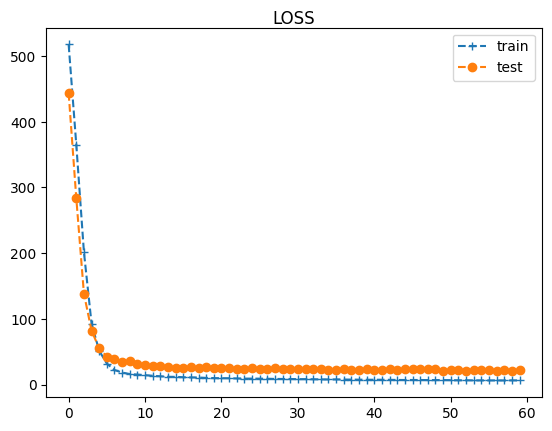

In [102]:
plt.plot(history.history['loss'],linestyle='--', marker='+', label='train' )
plt.plot(history.history['val_loss'],linestyle='--', marker='o', label='test')
plt.title('LOSS', pad=-50)
plt.legend()
#plt.title('lrate='+str(lrate), pad=-50)

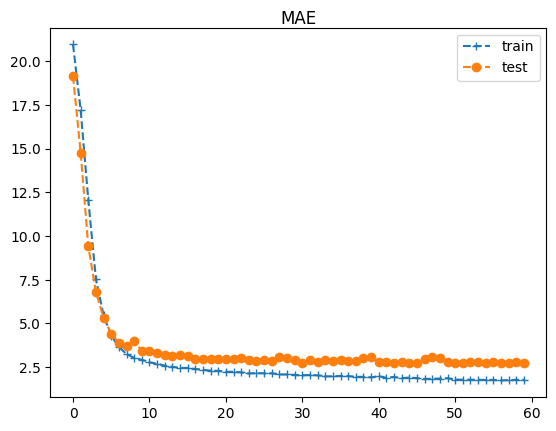

In [103]:
plt.plot(history.history['mae'],linestyle='--', marker='+', label='train' )
plt.plot(history.history['val_mae'],linestyle='--', marker='o', label='test')
plt.title('MAE', pad=-50)
plt.legend()

## Exe 9: Model Prediction

Use the trained neural network model, to predict the price of a given house and compare the result with the ground truth

In [104]:
my_house = [ 1.26425925, -0.48522739,  1.0436489 , -0.23112788,  1.37120745,
       -2.14308942,  1.13489104, -1.06802005,  1.71189006,  1.57042287,
        0.77859951,  0.14769795,  2.7585581 ]
real_price = 10.4

my_house = np.array([my_house])
prediction = model.predict(my_house)
print('Predicted price : ',prediction[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted price :  9.948538


In [105]:
predictions = model.predict(my_house)
print("Prediction : {:.2f} K$".format(predictions[0][0]))
print("Reality    : {:.2f} K$".format(real_price))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction : 9.95 K$
Reality    : 10.40 K$


## Exe 10 Early stoping

Create a neural network with the following specifications:

* Number of hidden layers: 2
* Number of units in each hidden layer: 64
* Activation function for the hidden layers: ReLU
* Output layer: Single unit with no activation function (for linear output)
* Loss function: Mean Squared Error (MSE)
* Additional metric to monitor during training: Mean Absolute Error (MAE)
* Optimizer: 'rmsprop'
* Apply dropout after each hidden layer with a dropout rate of 0.5 (50% of nodes dropped randomly for the following layer)
* Minibatch size: 100
* Use early stopping for fitting the model with patience=20 and epochs = 300
* Save the best model as 'model_best'
* Evaluate the saved model on the test data

In [106]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout

In [107]:
def build_model2 (shape):
  model = keras.models.Sequential()  
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(keras.layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  
  return model

model2=build_model2((13, ))

In [108]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
model2.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mae'])

In [109]:
history = model2.fit(x_train, y_train, epochs=300, batch_size=100, verbose=0, validation_data=(x_test, y_test), callbacks=[es, mc])
saved_model = load_model('best_model.h5')

Epoch 235: early stopping


In [110]:
test_loss, test_acc = saved_model.evaluate(x_test, y_test)
print(test_loss, test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 32.6562 - mean_absolute_error: 3.1033  
26.263368606567383 2.9606730937957764


# Classification with DNN

## Exe 1:  Import data

Import the cifra10 data set. The CIFAR-10 dataset consists of 60000
32 x 32 colour images in 10 classes, with 6000 images per class. There are
50000 training images and 10000 test images: https://www.tensorflow.org/datasets/catalog/cifar10

In [111]:
data = keras . datasets . cifar10
cifar10_data = data . load_data ()

## Exe 2 :

Before using a dataset, the datatype should be checked. Test *type(cifar10_data)*
for verifying the variable type. *len(cifar10_data)* is another command for
checking the data size.

In [112]:
type(cifar10_data)

tuple

In [113]:
len(cifar10_data)

2

## Exe 3: Train and Test

Load train and test images and labels with:

In [114]:
(train_images, train_labels),(test_images, test_labels) = cifar10_data

## Exe 4:

The images are 32 x 32 NumPy arrays, with pixel values ranging from 0
to 255. You can check an example with:

In [115]:
print ( train_images[0])
print ( train_images[0].shape )

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
(32, 32, 3)


In [116]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

## Exe 5: Chek

Check the dataset using the following commands:

In [117]:
print("train_images shape : ",train_images.shape)

print("train_labels size", len(train_labels))

print("train_labels",train_labels)

print("test_images shape : ",test_images.shape)

print("test_labels",test_labels)

train_images shape :  (50000, 32, 32, 3)
train_labels size 50000
train_labels [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
test_images shape :  (10000, 32, 32, 3)
test_labels [[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]


## Exe 6: Image Visualization

An interesting fact about the image is that it can be plotted. To visualize an image, you can use the following code:

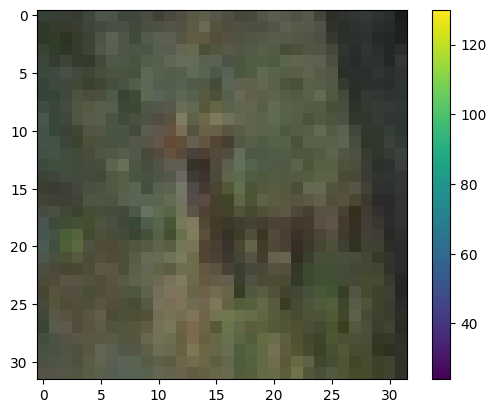

array([9], dtype=uint8)

In [118]:
index = 50
plt.figure()
plt.imshow(train_images[10])
plt.colorbar()
plt.show()

train_labels[index]

## Exe 7 : Display images and class name

To verify that the data is in the correct format and that you're ready to
build and train the network, let's display the first 25 images from the training
set and display the class name below each image.

In [119]:
class_names = [ 'airplane' , 'automobile' , 'bird' , 'cat' , 'deer' , 'dog' , 'frog' , 'horse' , 'ship' , 'truck']

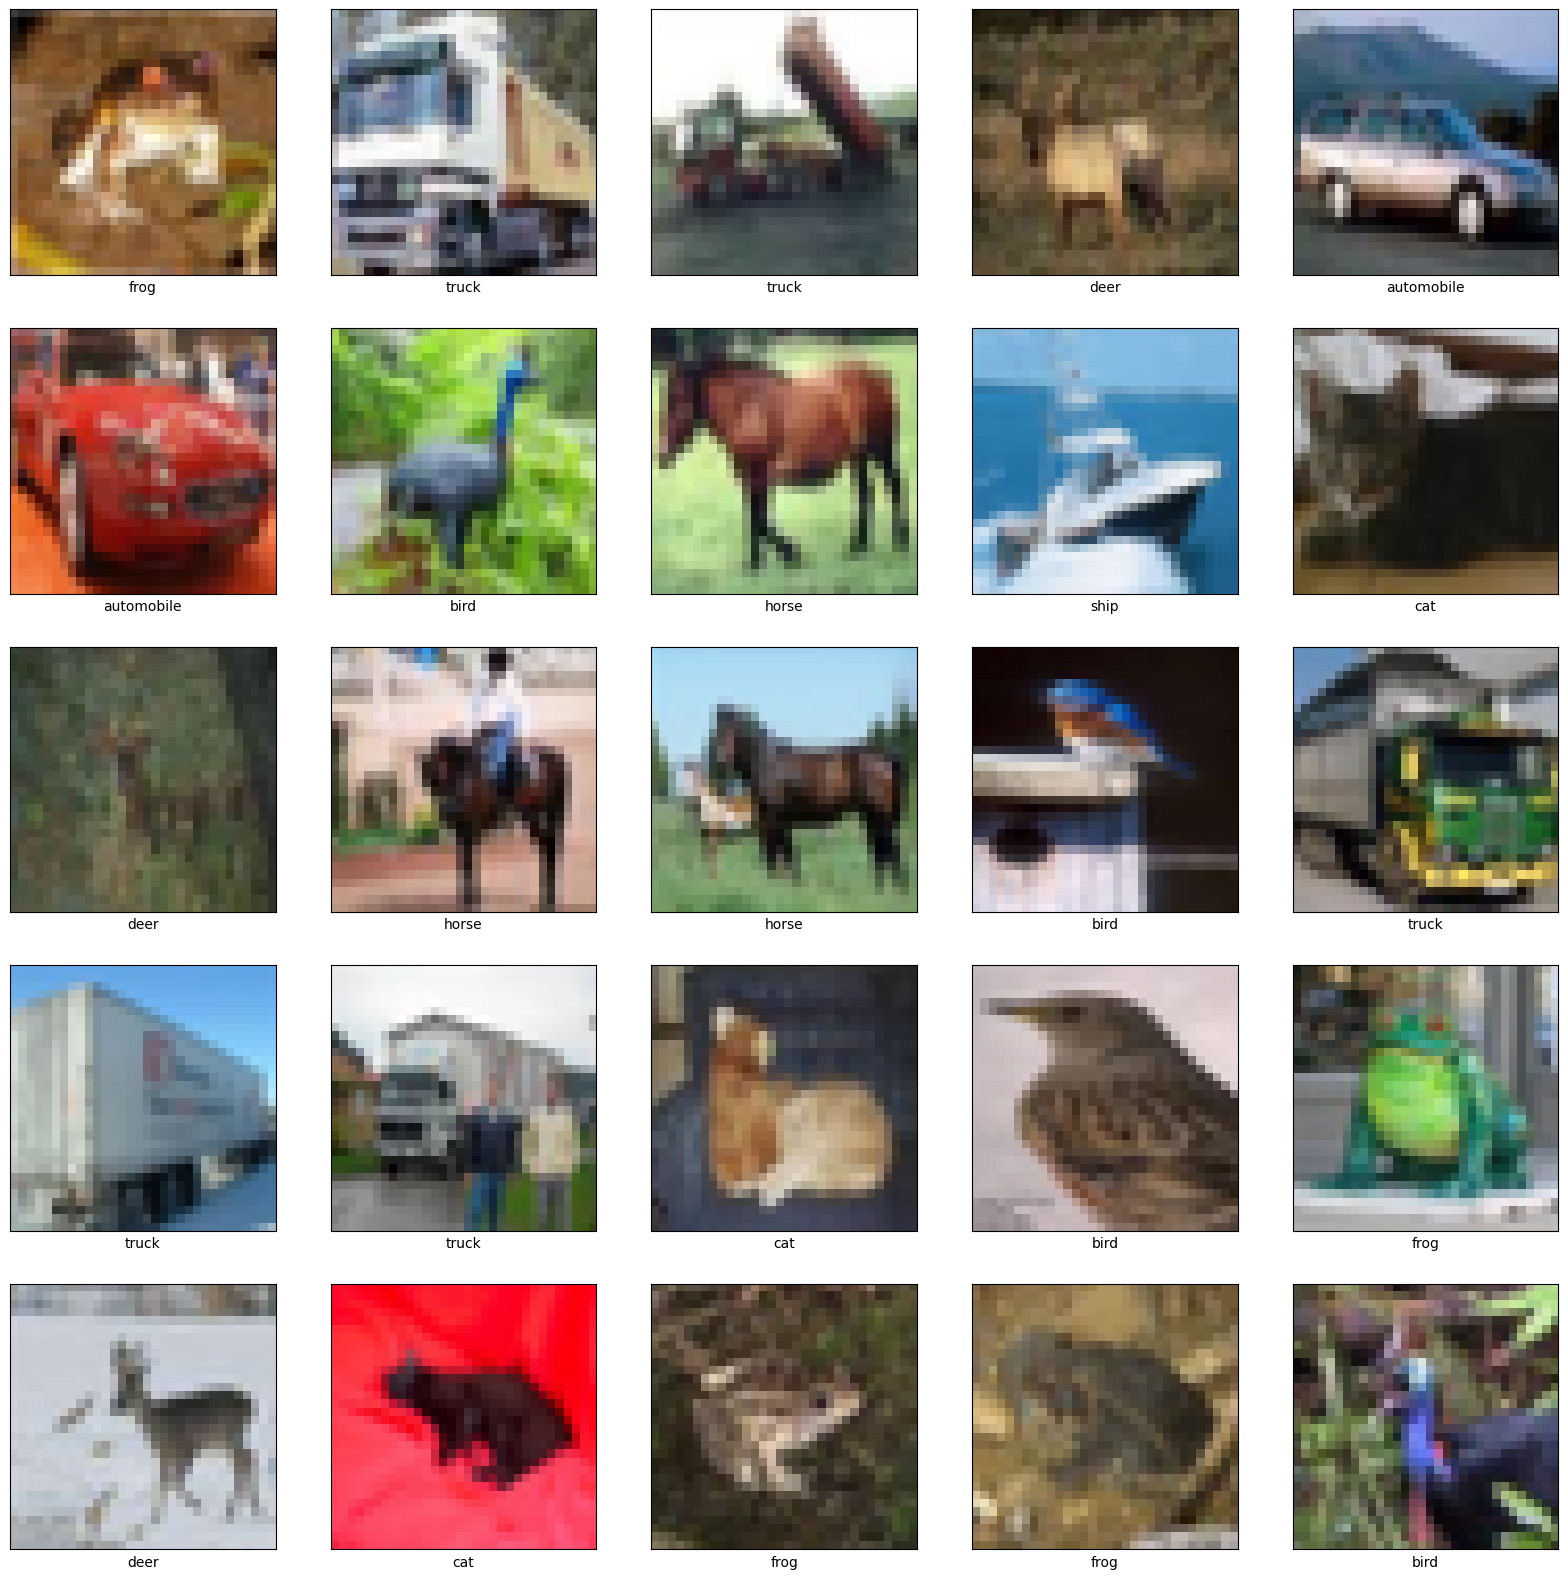

In [120]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
   # plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Exe 8: Dataset Normalization

Normalize the train and test sets using the following code

In [121]:
train_images_before = train_images
test_images_before = test_images

In [122]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [123]:
train_images

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

## Exo 9: Model

Build a neural network with the following structure:


1.   The first layer should be a **Flatten** layer that transforms the format of the images from a two-dimensional array (32 by 32 pixels) to a one-dimensional array (1024 pixels). This layer simply unstacks the rows of pixels in the image and lines them up. It has no parameters to learn and only reformats the data.

2.   After the pixels are flattened, the network should consist of two **Dense** layers. The first **Dense** layer should have 128 neurons.

3.   The second (and last) layer should be a **softmax** layer with 10 neurons, which returns an array of 10 probability scores that sum to 1. Each neuron contains a score indicating the probability that the current image belongs to one of the 10 classes.

In [124]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

c:\Users\auria\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Exe 10: Train the model

Compile the model using the appropriate optimizer, loss function, and metrics. Set the optimizer to 'adam', the loss function to 'sparse_categorical_crossentropy', and the metric to 'accuracy'.

Train the model, using the fit method on the model object. Pass in the train_images as the training data and train_labels as the corresponding labels.

In [125]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [126]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2799 - loss: 2.0076
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3734 - loss: 1.7452
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3933 - loss: 1.6915
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4047 - loss: 1.6599
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4138 - loss: 1.6395
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4251 - loss: 1.6102
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4218 - loss: 1.6125
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4331 - loss: 1.5924
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4356 - loss: 1.5774
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4390 - loss: 1.5729


## Exe 11: Evaluate the model

Chek the model performance on the test dataset.

In [127]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - 1ms/step - accuracy: 0.4255 - loss: 1.5947

Test accuracy: 0.4255000054836273


## Exo12

Now that the model has been trained, we can use it to make predictions on some images.

1.  Use the trained model to make predictions on the test_images dataset by calling model.predict(test_images). This will generate predictions for each image in the testing set.

2. Print the first, second, and third element of the predicted test set. Each element contains 10 values representing the probability of each label.

3. After printing the predicted test set, use the np.argmax() function to choose the label with the highest probability for each element.

4. Compare the predicted label for the first three elements with their actual labels. How many of them are correct?

In [128]:
predictions = model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step


In [129]:
predictions[10]

array([0.32452133, 0.00747876, 0.06379138, 0.01299613, 0.03339465,
       0.00634923, 0.0057251 , 0.00107499, 0.5371914 , 0.00747699],
      dtype=float32)

In [130]:
np.argmax(predictions[10])

np.int64(8)

In [131]:
test_labels[10]

array([0], dtype=uint8)

## Exe13 :  Checking Predicted Labels

Now, let's write a function to check the predicted labels and visualize the results. The function should display the predicted labels similar to the above Figure, indicating the probability of the predicted label. If the prediction is correct, the label should be displayed in blue, otherwise in red.

In [132]:
def plot_image(i, predictions_array, true_label, img):

  true_label = true_label[0]
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

In [133]:
class_names = [ 'airplane' , 'automobile' , 'bird' , 'cat' , 'deer' , 'dog' , 'frog' , 'horse' , 'ship' , 'truck']

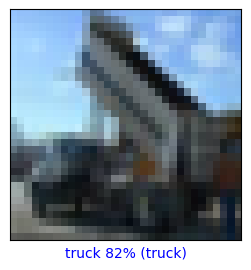

array([1.0344813e-01, 2.9450353e-02, 5.6494870e-03, 1.1214306e-02,
       1.0828438e-03, 3.4692874e-03, 1.3189604e-04, 6.8181646e-03,
       1.4168588e-02, 8.2456696e-01], dtype=float32)

In [134]:
i = 50
plt.figure(figsize=(6,3))
plot_image(i, predictions[i], test_labels[i], test_images[i])
plt.show()  
predictions[i]

# Homework Assignment: Deep Neural Network Classification with Fashion MNIST

Redo the classification part, this time utilizing the Fashion MNIST dataset and a DNN model with three Dense layers. The first and second Dense layers should have 128 neurons each. Additionally, incorporate the following specifications:

* Apply dropout after each hidden layer with a dropout rate of 0.25 (25% of neurons dropped randomly for the subsequent layer).
*  Set the batch size to 512.
*  Implement early stopping while fitting the model with a patience value of 20 and a maximum number of epochs set to 200.
*  Save the best model as 'model_best'.
*  Evaluate the saved model on the test data.

**For the submission of your work, please submit your completed assignment in HTML format.**



### Load Fashion MNIST dataset

In [164]:
fashion_mnist_data = keras.datasets.fashion_mnist
fashion_mnist = fashion_mnist_data.load_data()

In [165]:
type(fashion_mnist)

tuple

In [166]:
len(fashion_mnist)

2

In [167]:
(train_images, train_labels),(test_images, test_labels) = fashion_mnist
print (train_images[0])
print (train_images[0].shape )

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

In [168]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [169]:
print("train_images shape : ",train_images.shape)

print("train_labels size", len(train_labels))

print("train_labels",train_labels)

print("test_images shape : ",test_images.shape)

print("test_labels",test_labels)

train_images shape :  (60000, 28, 28)
train_labels size 60000
train_labels [9 0 0 ... 3 0 5]
test_images shape :  (10000, 28, 28)
test_labels [9 2 1 ... 8 1 5]


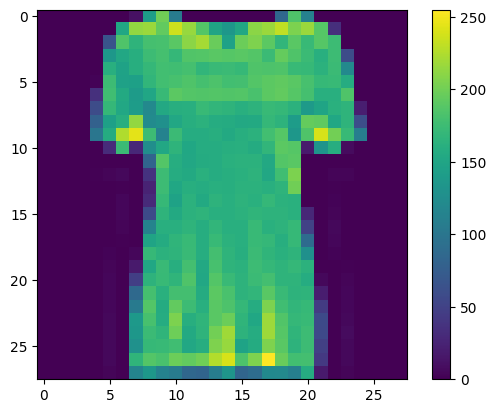

np.uint8(3)

In [170]:
index = 50
plt.figure()
plt.imshow(train_images[10])
plt.colorbar()
plt.show()

train_labels[index]

In [171]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

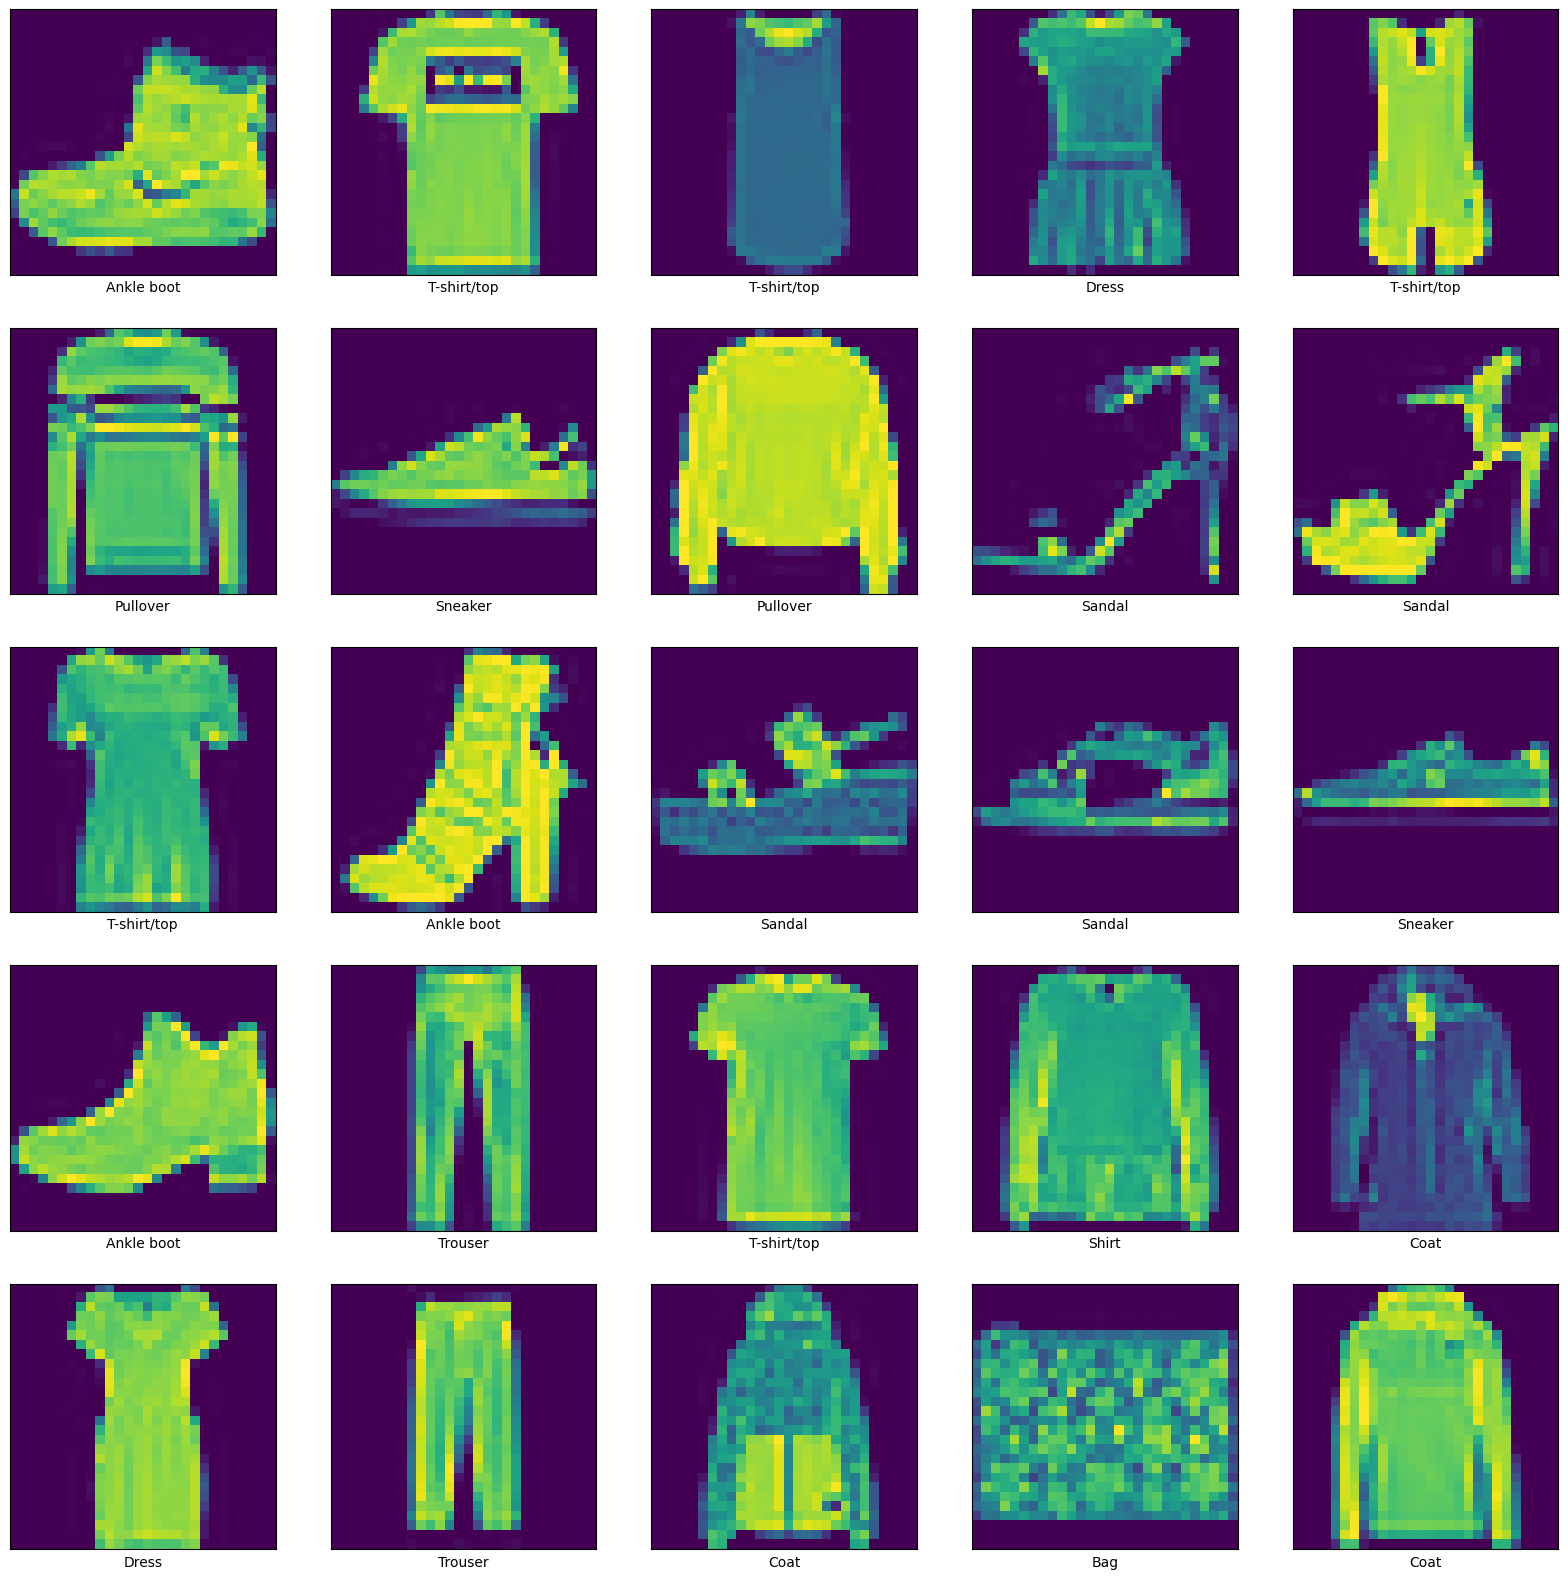

In [172]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
   # plt.   grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [173]:
train_images_before = train_images
test_images_before = test_images

In [174]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [175]:
train_images

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [185]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28,1)),
    keras.layers.Dense(128, activation='relu'),
    Dropout(0.25),
    keras.layers.Dense(128, activation='relu'),
    Dropout(0.25),
    keras.layers.Dense(128, activation='relu'),
    Dropout(0.25),
    keras.layers.Dense(10, activation='softmax')
])

In [186]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [189]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('model_best.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
history = model.fit(train_images, train_labels, epochs=200, batch_size=512)#, verbose=0, validation_data=(test_images, test_labels), callbacks=es)

Epoch 1/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8980 - loss: 0.2767
Epoch 2/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8989 - loss: 0.2693
Epoch 3/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9000 - loss: 0.2688
Epoch 4/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9023 - loss: 0.2651
Epoch 5/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9026 - loss: 0.2609
Epoch 6/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9017 - loss: 0.2636
Epoch 7/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9052 - loss: 0.2599
Epoch 8/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9016 - loss: 0.2628
Epoch 9/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9053 - loss: 0.2582
Epoch 10/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9078 - loss: 0.2485
Epoch 11/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9070 - loss: 0.2478
Epoch 12/200
118/118 ━━━━━━━━━━━━━━━━━━━━

In [190]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - 1ms/step - accuracy: 0.8935 - loss: 0.4139

Test accuracy: 0.8934999704360962


In [191]:
saved_model = load_model('model_best.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'model_best.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [159]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 0s - 1ms/step - accuracy: 0.1000 - loss: 4.8520

Test accuracy: 0.10000000149011612


In [ ]:
predictions = model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


In [153]:
predictions[10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [154]:
np.argmax(predictions[10])

np.int64(0)

In [163]:
test_labels[10]

np.uint8(4)

In [156]:
def plot_image(i, predictions_array, true_label, img):

  plt.xticks([])
  plt.yticks([])
  plt.imshow(img.reshape(28, 28))
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

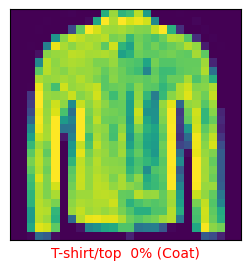

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [157]:
i = 50
plt.figure(figsize=(6,3))
plot_image(i, predictions[i], test_labels[i], test_images[i])
plt.show()
predictions[i]

# Converting a notebook to html

In [158]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# #%%shell
# !jupyter nbconvert --to html '/content/gdrive/MyDrive/Colab Notebooks/DL_Lab1_NN.ipynb'